<a href="https://colab.research.google.com/github/SananSuleymanov/MRI_cancer_U-NET/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Requirements

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import zipfile
import os


#Download Kaggle dataset

In [2]:
!pip install kaggle-cli

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 74 kB 1.6 MB/s 
     |████████████████████████████████| 4.2 MB 51.0 MB/s 
     |████████████████████████████████| 112 kB 68.5 MB/s 
     |████████████████████████████████| 147 kB 70.3 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
  Created wheel for kaggle-cli: filename=kaggle_cli-0.12.13-py3-none-any.whl size=9486 sha256=c5da5594249b1440a028b845efe4981c869336984eaaae4c2a43f21dfe539147
  Stored in directory: /root/.cache/pip/wheels/e0/8c/cb/e46bee8185f2c855639465c16eee15582dc3f78484bfa998f1
  ERROR: Failed building wheel for lxml
  Running setup.py clean for lxml
  Created wheel for PrettyTable: filename=prettytable-0.7.2-py3-none-any.whl size=13714 sha256=e92315a2fc49c190cb060de666e88eb349ef6f5c53bf42ec9645feaf7291c2c3
  Stored in directory: /root/.cache/pip/wheels/48/6d/77/9517cb933af254f51a446f1a5ec9c2be3e45f17384940bce68
  Create

In [3]:
cd ..

/


In [4]:
cd content

/content


In [9]:
cp /content/kaggle.json /root/.kaggle/

In [10]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

100% 712M/714M [00:17<00:00, 44.3MB/s]
100% 714M/714M [00:17<00:00, 43.8MB/s]


#Dataset Preprocessing

In [11]:
#unzipping the files
try:
  with zipfile.ZipFile('/content/lgg-mri-segmentation.zip') as z:
    z.extractall()
    print('Done')
except:
  FileNotFoundError()

Done


In [12]:
#images and masks are readed separately and appended to list. 
path='/content/lgg-mri-segmentation/kaggle_3m'
images=[]
masks=[]
fig=plt.figure()
for filename in os.listdir(path):
  f= os.path.join(path, filename)
  if os.path.isdir(f):
    iters = int(len(os.listdir(f))/2)
    for i in range(1, iters):
      image= os.path.join(f, filename )+'_'+str(i)+'.tif'
      mask= os.path.join(f, filename )+'_'+str(i)+'_mask.tif'
      image=cv2.imread(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(mask, cv2.COLOR_BGR2RGB)
      images.append(image)
      masks.append(mask)
      
#converting lists to numpy array
image_array=np.array(images)
mask_array=np.array(masks)


<Figure size 432x288 with 0 Axes>

In [13]:
class preprocess():
  def __init__(self, image, mask):
    self.image=image
    self.mask=mask

  def preprocess_image(self):
    """
    Resizing all images and normalizing 
    """
    new_image=[]
    for i in range(len(self.image)):
      image_sz= cv2.resize(self.image[i], (128, 128))
      image_sz= image_sz/255.0
      image_sz=image_sz.astype(np.float32)
      new_image.append(image_sz)
    return new_image

  def preprocess_mask(self):
    """
    Resizing all masks and normalizing
    """
    new_mask=[]
    for i in range(len(self.mask)):
      mask_sz= cv2.resize(self.mask[i], (128, 128))
      mask_sz= mask_sz/255.0
      mask_sz=mask_sz.astype(np.float32)
      mask_sz = np.expand_dims(mask_sz, axis=-1)
      new_mask.append(mask_sz)
    return new_mask


In [14]:
process=preprocess(image_array, mask_array)
last_images= process.preprocess_image()
last_mask= process.preprocess_mask()

In [15]:
#preprocessed images and masks list are converted to numpy array
image_array=np.array(last_images)
mask_array=np.array(last_mask)

BATCH_SIZE=64
BUFFER_SIZE=1000

#separation of images and masks to train and test datasets and then, conversion to tensors
train_image, test_image, train_mask, test_mask= train_test_split(image_array, mask_array,test_size=0.33, random_state=42 )
train_dataset = tf.data.Dataset.from_tensor_slices((image_array, mask_array))
test_dataset=tf.data.Dataset.from_tensor_slices((test_image, test_mask))

#shuffling and batching the train and test dataset
train_dataset=train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_dataset=test_dataset.batch(BATCH_SIZE)

#Visualization of dataset

In [16]:
#visualization of images with masks
def visualize(len_of_image):
  plt.figure(figsize=(20,20))
  for i in range (1, len_of_image,2):
    plt.subplot(1,len_of_image, i)
    plt.imshow(train_image[i])
    plt.subplot(1,len_of_image, i+1)
    plt.imshow(np.squeeze(train_mask[i]))

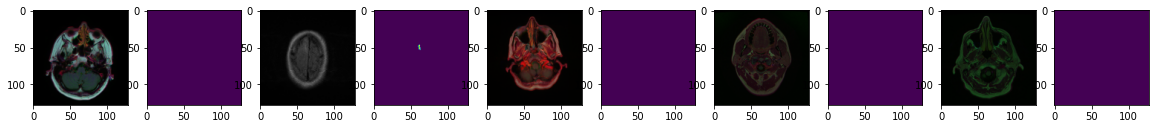

In [18]:
visualize(10)

#U-NET model structure

In [17]:
def conv2d (input_tensor, n_filters, kernel_size=3):

  x= input_tensor
  for i in range(2):
    x= tf.keras.layers.Conv2D(filters= n_filters, kernel_size= (kernel_size, kernel_size), 
                              kernel_initializer='he_normal', padding='same')(x)
    x=tf.keras.layers.Activation('relu')(x)
  return x


def encoder_block(inputs, n_filters = 64, pool_size=(2, 2), dropout=0.3):

  f= conv2d(inputs, n_filters=n_filters)
  p= tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
  p= tf.keras.layers.Dropout(dropout)(p)

  return f, p

def encoder(inputs):

  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2, 2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters = 128, pool_size=(2, 2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters = 256, pool_size=(2, 2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters = 512, pool_size=(2, 2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

def bottleneck(inputs):
  bottle_neck= conv2d(inputs, n_filters= 1024)
  return bottle_neck

def decoder_block(inputs, conv_output, kernel_size, strides, n_filters, droupout=0.3):

  u = tf.keras.layers.Conv2DTranspose(filters= n_filters, strides = strides, kernel_size=kernel_size, padding='same')(inputs)
  s= tf.keras.layers.concatenate([u, conv_output])
  s= tf.keras.layers.Dropout(droupout)(s)
  s= conv2d(s, kernel_size=3, n_filters= n_filters)

  return s

def decoder(inputs, conv_output, output_channels):

  f1,f2, f3,  f4= conv_output
  s6 = decoder_block(inputs, f4, n_filters= 512, strides= (2, 2), kernel_size=(3,3), droupout=0.3)
  s7 = decoder_block(s6, f3, n_filters= 256, strides= (2, 2), kernel_size=(3,3), droupout=0.3)
  s8 = decoder_block(s7, f2, n_filters= 128, strides= (2, 2), kernel_size=(3,3), droupout=0.3)
  s9 = decoder_block(s8, f1, n_filters= 64, strides= (2, 2), kernel_size=(3,3), droupout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation ='softmax')(s9)


  return outputs



In [19]:
OUTPUT_CHANNELS=2
def unet():

  inputs= tf.keras.layers.Input(shape=(128, 128, 3,))
  encoder_output, convs= encoder(inputs)

  bottle_output= bottleneck(encoder_output)
  output= decoder(inputs=bottle_output, conv_output=convs, output_channels=OUTPUT_CHANNELS )

  model= tf.keras.Model(inputs=inputs, outputs = output)
  return model

model= unet()

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

#Training the model

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
TRAIN_LENGTH = len(train_image)
BATCH_SIZE=64
STEPS_PER_EPOCH= TRAIN_LENGTH//BATCH_SIZE
model_history=model.fit(train_image, train_mask, epochs=30)

Epoch 1/30
80/80 [==============================] - 61s 544ms/step - loss: 0.4063 - accuracy: 0.9775
Epoch 2/30
80/80 [==============================] - 37s 461ms/step - loss: 0.0285 - accuracy: 0.9904
Epoch 3/30
80/80 [==============================] - 37s 467ms/step - loss: 0.0267 - accuracy: 0.9906
Epoch 4/30
80/80 [==============================] - 37s 463ms/step - loss: 0.0260 - accuracy: 0.9909
Epoch 5/30
80/80 [==============================] - 37s 467ms/step - loss: 0.0246 - accuracy: 0.9911
Epoch 6/30
80/80 [==============================] - 37s 464ms/step - loss: 0.0237 - accuracy: 0.9913
Epoch 7/30
80/80 [==============================] - 37s 466ms/step - loss: 0.0233 - accuracy: 0.9915
Epoch 8/30
80/80 [==============================] - 37s 466ms/step - loss: 0.0234 - accuracy: 0.9915
Epoch 9/30
80/80 [==============================] - 37s 466ms/step - loss: 0.0221 - accuracy: 0.9916
Epoch 10/30
80/80 [==============================] - 37s 465ms/step - loss: 0.0224 - accura

In [23]:
results= model.predict(test_image)

40/40 [==============================] - 8s 196ms/step


In [24]:
result= model.evaluate(test_image, test_mask,verbose=0)

In [25]:
print('Accuracy of model: {}'.format(result[1]))

Accuracy of model: 0.9949853420257568


#Testing the model

In [32]:
def result_mask(result):
  pred_mask = tf.argmax(result, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  image=np.array(pred_mask)
  last_mask=np.squeeze(image)
  
  return last_mask

def segmented_image(mask, test_image):
  blue_mask= np.zeros(shape= (mask.shape[0], mask.shape[1], 3), dtype=np.int32)
  for i in range(test_image.shape[0]):
    for j in range(test_image.shape[1]):
      if mask[i][j].any()==1:
        blue_mask[i][j][2]=255
  segmented_image= cv2.addWeighted(np.array(test_image*255, dtype=np.int32), 0.5, blue_mask, 0.5, 0.0, dtype=cv2.CV_32F)
  return segmented_image

def visualize(result, test_mask, test_image):
  unet_mask= result_mask(result)
  segmented_image_unet= segmented_image(unet_mask, test_image)
  segmented_image_real= segmented_image(test_mask, test_image)
  plt.figure(figsize=(20,20))

  plt.subplot(1,5,1)
  plt.imshow(test_image)
  plt.title(' Brain MRI')

  plt.subplot(1,5,2)
  plt.imshow(segmented_image_unet.astype(np.uint8))
  plt.title('Predicted segmentation')

  plt.subplot(1, 5, 3)
  plt.imshow(segmented_image_real.astype(np.uint8))
  plt.title('Real segmentation')

  plt.subplot(1, 5, 4)
  plt.imshow(unet_mask)
  plt.title('Predicted mask')

  plt.subplot(1, 5, 5)
  plt.imshow(np.squeeze(test_mask))
  plt.title('Real mask')

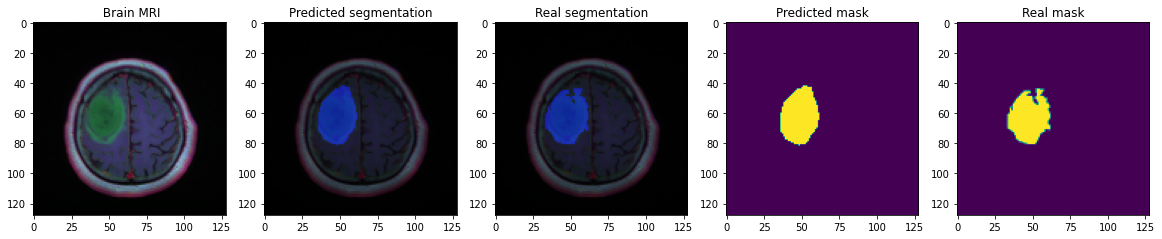

In [44]:
visualize(results[24], test_mask[24], test_image[24])